In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [3]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

In [8]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=False)

# Training

iter 1: 5.91555
iter 2: 7.89988
iter 3: 6.64765
iter 4: 4.49072
iter 5: 3.84374
iter 6: 3.88169
iter 7: 3.21882
iter 8: 3.26895
iter 9: 2.6589
iter 10: 2.26263
iter 11: 1.95126
iter 12: 1.75463
iter 13: 1.42846
iter 14: 1.36884
iter 15: 0.977861
iter 16: 0.923681
iter 17: 0.926362
iter 18: 0.951006
iter 19: 0.711123
iter 20: 0.598564
iter 21: 0.649341
iter 22: 0.70202
iter 23: 0.510166
iter 24: 0.409769
iter 25: 0.472291
iter 26: 0.451537
iter 27: 0.353588
iter 28: 0.370525
iter 29: 0.335658
iter 30: 0.355871
iter 31: 0.308193
iter 32: 0.240488
iter 33: 0.267416
iter 34: 0.209725
iter 35: 0.209873
iter 36: 0.217078
iter 37: 0.209993
iter 38: 0.200971
iter 39: 0.182789
iter 40: 0.169191
iter 41: 0.213572
iter 42: 0.220479
iter 43: 0.171551
iter 44: 0.152117
iter 45: 0.182704
iter 46: 0.171449
iter 47: 0.158782
iter 48: 0.174088
iter 49: 0.137775
iter 50: 0.128304
iter 51: 0.128822
iter 52: 0.120807
iter 53: 0.146676
iter 54: 0.148672
iter 55: 0.127745
iter 56: 0.120266
iter 57: 0.126448

iter 423: 0.023163
iter 424: 0.012498
iter 425: 0.011166
iter 426: 0.0141308
iter 427: 0.01316
iter 428: 0.0193632
iter 429: 0.01493
iter 430: 0.0239389
iter 431: 0.022778
iter 432: 0.0112551
iter 433: 0.0237406
iter 434: 0.0180395
iter 435: 0.0157686
iter 436: 0.0101085
iter 437: 0.00888721
iter 438: 0.0158284
iter 439: 0.0353832
iter 440: 0.0198263
iter 441: 0.0220766
iter 442: 0.0125638
iter 443: 0.019848
iter 444: 0.0203251
iter 445: 0.0158252
iter 446: 0.015276
iter 447: 0.0265156
iter 448: 0.0159153
iter 449: 0.0190076
iter 450: 0.0246089
iter 451: 0.0236916
iter 452: 0.0106621
iter 453: 0.0100893
iter 454: 0.0181115
iter 455: 0.0228049
iter 456: 0.0150657
iter 457: 0.0226474
iter 458: 0.0191578
iter 459: 0.0281841
iter 460: 0.0174469
iter 461: 0.0170165
iter 462: 0.00809832
iter 463: 0.0122432
iter 464: 0.0144178
iter 465: 0.0188307
iter 466: 0.0298684
iter 467: 0.0274869
iter 468: 0.0182409
iter 469: 0.0112324
iter 470: 0.0120808
iter 471: 0.0185517
iter 472: 0.00919326
iter 47

iter 834: 0.0101366
iter 835: 0.0120226
iter 836: 0.0123636
iter 837: 0.0157665
iter 838: 0.005944
iter 839: 0.0116448
iter 840: 0.0172227
iter 841: 0.0183736
iter 842: 0.0160339
iter 843: 0.010561
iter 844: 0.016092
iter 845: 0.00901444
iter 846: 0.0107841
iter 847: 0.0155263
iter 848: 0.0114559
iter 849: 0.0109542
iter 850: 0.0137944
iter 851: 0.0144826
iter 852: 0.00859386
iter 853: 0.00884646
iter 854: 0.0079388
iter 855: 0.00728791
iter 856: 0.00757816
iter 857: 0.012989
iter 858: 0.00880244
iter 859: 0.0149491
iter 860: 0.00944727
iter 861: 0.00614236
iter 862: 0.00815125
iter 863: 0.0163309
iter 864: 0.0129265
iter 865: 0.0128289
iter 866: 0.00936062
iter 867: 0.00635743
iter 868: 0.00577554
iter 869: 0.0065075
iter 870: 0.0119167
iter 871: 0.0114328
iter 872: 0.00649253
iter 873: 0.0166258
iter 874: 0.0123666
iter 875: 0.00617304
iter 876: 0.0104827
iter 877: 0.00775965
iter 878: 0.0146683
iter 879: 0.0150289
iter 880: 0.00959003
iter 881: 0.00873092
iter 882: 0.007685
iter 883

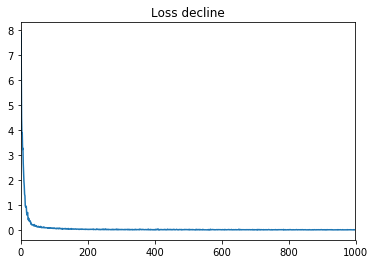

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]

threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

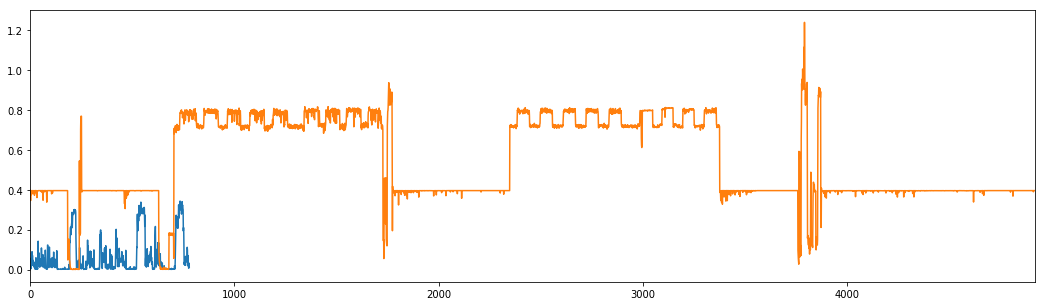

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

In [14]:
beta = 0.1
tp = np.array(abnormal_score)[abnormal_score>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[normal_score>threshold].size
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9611574273488103

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Predict result :


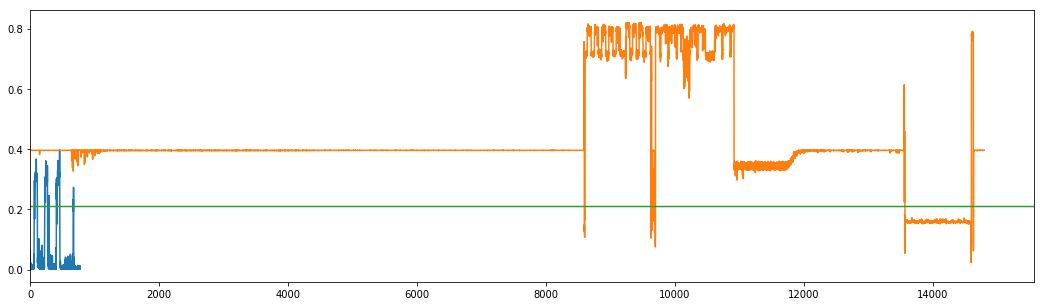

In [15]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [16]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9288080589547698

In [17]:
print(tp,fp,tn,fn,P,R)

13738 1062 627 153 0.9282432432432433 0.988985674177525
